## Worksheet 9

### Group 22 Eaton Heidegger and Shannon Schröder

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import hydro_routines_2d as hydro2d

#### Computational Fluid Mechanics II– Finite volume in 2D

##### a) Run the diagonal advection test from the lecture for a Gaussian density peak. Use a similar set-up for density and pressure as for the 1D advection....

First we set up the simulation parameters, with a constant velocity (u,v) = (1,1) and the pressure P0 constant at 0.1 and the rest of the parameters (t start = 0 and t end = 2).

In [2]:
# 1. simulation parameters
N       = 64 # grid cells per dimension
Lbox    = 1.0 # domain is [0,1) × [0,1)
dx      = Lbox / N
gamma   = 1.4 
CFL     = 0.9
t_end   = 2.0
output_times = [1.0, 2.0] # store snapshots close to these


# primitive background state
rho0    = 1.0
P0      = 0.1
u0, v0  = 1.0, 1.0  # diagonal flow

Then we Initialize the 2D Gaussian density profile, initially centered. 

In [3]:
# Gaussian bump parameters
amp     = 1.0  # peak height above background
sigma   = 0.05 * Lbox
x0, y0  = 0.5 * Lbox, 0.5 * Lbox # initial centre


# 2. initial conditions on the cell centres
x = (np.arange(N) + 0.5) * dx
y = (np.arange(N) + 0.5) * dx
X, Y = np.meshgrid(x, y, indexing='ij')

rho = rho0 + amp * np.exp(-((X - x0)**2 + (Y - y0)**2) / sigma**2)

We set up the initial primitive variables and convert them to the conserved ones, using the funtion `primitive_to_conserved` from the python file

In [4]:
# pack primitive array Q[...,0:4] = (ρ,u,v,P)
Q = np.empty((N, N, 4))
Q[..., 0] = rho
Q[..., 1] = u0
Q[..., 2] = v0
Q[..., 3] = P0

# convert to conserved variables U[...,0:4] = (ρ,ρu,ρv,E)
U = hydro2d.primitive_to_conserved(Q, gamma)

Then we implement the integration timeloop, which is a while-loop that calls the 'hydro_step_unsplit' function until the total time reaches t=2.0. The CFL-limited time-step is chosen automatically each iteration.

In [5]:
# 3. time-integration loop
snapshots = {}
t, step = 0.0, 0
while t < t_end - 1e-14: # tiny tolerance
    # advance with the unsplit scheme (Strang–unsplit also works)
    U, t, step = hydro2d.hydro_step_unsplit(
        U, t=t, tmax=t_end, step=step,
        CFLfac=CFL, dx=dx, gamma=gamma
    )

    # store snapshots the first time we pass an output time
    for tt in output_times:
        if (tt not in snapshots) and (t >= tt):
            snapshots[tt] = hydro2d.conserved_to_primitive(U.copy(), gamma)

print(f"done: {step} steps,  t = {t:.6f}")


done: 392 steps,  t = 2.000000


At last, we plot the solution: We output snapshots. As soon as the running time passes t=1 and t=2 the code records a copy of the primitive variables. These are later compared to the initial field.

L1 error in ρ at t = 1.0: 4.662e-03
L1 error in ρ at t = 2.0: 6.424e-03


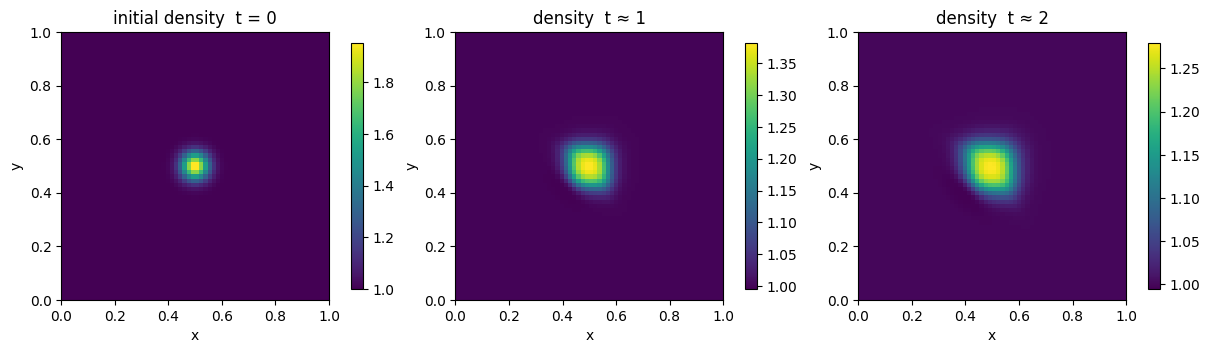

In [6]:

fig, axes = plt.subplots(1, 3, figsize=(12, 4), constrained_layout=True)

def show_density(ax, Qsnap, title):
    im = ax.imshow(Qsnap[..., 0].T, origin='lower', extent=[0, 1, 0, 1])
    ax.set_title(title)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

show_density(axes[0], Q,              'initial density  t = 0')
show_density(axes[1], snapshots[1.0], 'density  t ≈ 1')
show_density(axes[2], snapshots[2.0], 'density  t ≈ 2')

# L1-error of density at t = 1, 2  (should be small – pure advection)
for tt in output_times:
    err = np.abs(snapshots[tt][..., 0] - Q[..., 0]).sum() / (N * N)
    print(f"L1 error in ρ at t = {tt:3.1f}: {err:.3e}")

plt.show()

The plots show the density at t=0,1,2.
Because the flow advects the bump one full box length per unit time, the exact solution after 1 and 2 box-crossings is identical to the start; the script prints the L¹-error to confirm the solver’s accuracy.

Left plot ($t=0$):  a perfectly round, bright-yellow Gaussian "blob" centred at `(0.5,0.5)` on a uniform background.

Middle plot ($t=1$):  the blob has moved diagonally by one full box length and has just re-entered the domain through the lower-left periodic boundary. Its peak value is a bit lower and its outline now looks slightly square.

Right plot($t=2$): another full crossing later: the peak is broader and more flattened than at $t\approx 1$  and the squaring is more pronounced.


What the deviations mean:
- Lower peak & broader footprint – numerical viscosity inherent in the Riemann solver smooths gradients, spreading mass over neighbouring cells.

- Squarish outline – the limiter constructs slopes only along the grid axes, so an initially isotropic blob picks up a mild grid-aligned anisotropy.

- Error growth – the printed L¹-errors quantify the integrated absolute difference from the initial density. A few $10^{-3}$ on a background of 1 is well within expectations for a second-order scheme at this resolution.

If we f.e. switch to the split integrator, we can see a faster diffustion.


#### The complete mainn driver function: 

In [25]:
# Main driver function: 
# function to run one advection simulation and return L1 error and average dt 
def run_sim(N, CFLfac, t_end=1.0, gamma=5.0/3.0, amp=1.0, P0=0.1, u0=1.0, v0=1.0):
    """
    Run one diagonal-advection test and return
        Δx (= 1/N),  ⟨Δt⟩  (average time-step),  and L1-error of ρ at t_end
    """
    Lbox = 1.0
    dx = Lbox / N
    # grid
    x = (np.arange(N) + 0.5) * dx
    y = (np.arange(N) + 0.5) * dx
    X, Y = np.meshgrid(x, y, indexing='ij')
    # initial primitive state
    rho0 = 1.0 + amp * np.exp(-((X-0.5)**2 + (Y-0.5)**2) / (0.05**2))
    Q = np.empty((N, N, 4))
    Q[...,0] = rho0
    Q[...,1] = u0
    Q[...,2] = v0
    Q[...,3] = P0
    U = hydro2d.primitive_to_conserved(Q, gamma)
    # time loop
    t = 0.0
    step = 0
    total_dt = 0.0
    while t < t_end - 1e-12:
        U, t, step = hydro2d.hydro_step_unsplit(U, t=t, tmax=t_end, step=step,
                                                CFLfac=CFLfac, dx=dx, gamma=gamma)
    avg_dt = t_end / step
    # convert back
    Q_end = hydro2d.conserved_to_primitive(U, gamma)
    err = np.abs(Q_end[...,0] - Q[...,0]).sum() / (N*N)
    return dx, avg_dt, err


##### b) Determine the order of convergence of the method by plotting the error between the advected solution at t = 1 and the initial condition (as usual in a log-log plot) against the resolution– varying first the spatial resolution and then the time step size (by adjusting CFLfac ). Measure the order of the method by fitting the slope.

First we vary the spacial resolution by varying N and measure the order of the metod fitting a linear fit using `np.polyfit`

In [27]:
# 1) spatial convergence: vary N
Nlist = [32, 64, 128]  # Breaks down after 128 (or takes forever idk, I let it run for 10 mins, didnt finish)
dxs, errs_dx = [], []
for N in Nlist:
    dx, avg_dt, err = run_sim(N=N, CFLfac=0.5)
    dxs.append(dx)
    errs_dx.append(err)

# linear fit in log space
p_dx = np.polyfit(np.log10(dxs), np.log10(errs_dx), 1)
order_space = p_dx[0]

Now we vary the time step size, by adjusting CFLfac

In [28]:
# 2) temporal convergence: vary CFLfac (dt size) at fixed resolution
N_fixed = 64
CFLlist = [0.05, 0.1, 0.2, 0.4, 0.8, 0.9]  # Going above 1 is unsafe; going below 0.05 just wastes CPU time without noticeable accuracy gains in most cases.
dts, errs_dt = [], []
for cfl in CFLlist:
    dx, avg_dt, err = run_sim(N=N_fixed, CFLfac=cfl)
    dts.append(avg_dt)
    errs_dt.append(err)

p_dt = np.polyfit(np.log10(dts), np.log10(errs_dt), 1)
order_time = p_dt[0]

Now we plot the results and the convergence order (fittet slope) 

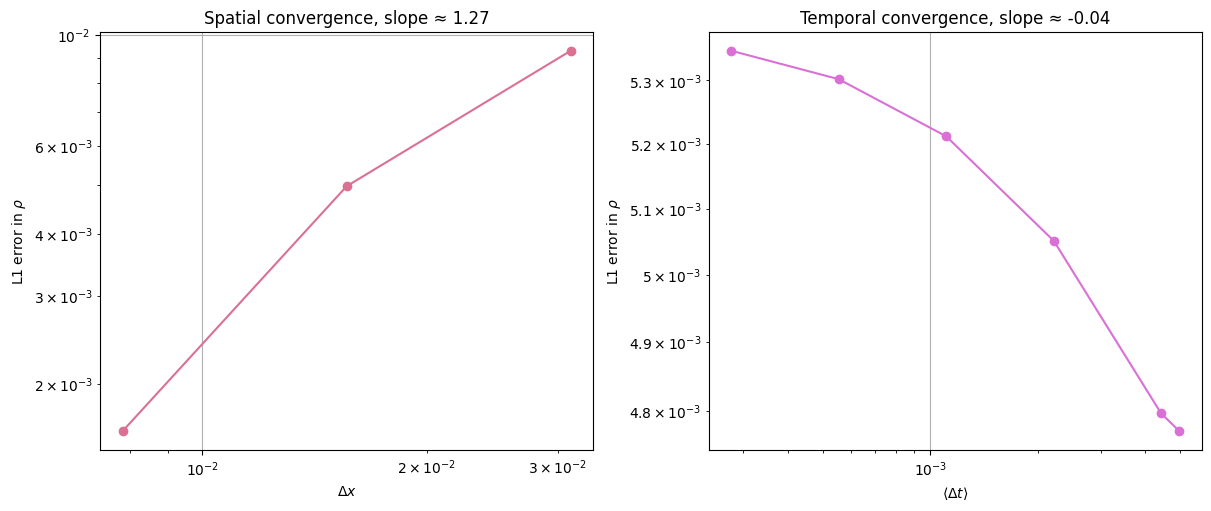

Spatial convergence order (slope): 1.2661967696881478
Temporal convergence order (slope): -0.04148013790192889


In [29]:

fig, axes = plt.subplots(1, 2, figsize=(12, 5), constrained_layout=True)

# Spatial convergence
plt.sca(axes[0])   
plt.loglog(dxs, errs_dx, marker='o', linestyle='-', color='palevioletred')
plt.xlabel(r'$\Delta x$')
plt.ylabel(r'L1 error in $\rho$')
plt.title(f'Spatial convergence, slope ≈ {order_space:.2f}') 
plt.grid(True)

# Temporal convergence
plt.sca(axes[1])    
plt.loglog(dts, errs_dt, marker='o', linestyle='-', color='orchid')
plt.xlabel(r'$\langle \Delta t \rangle$')
plt.ylabel(r'L1 error in $\rho$')
plt.title(f'Temporal convergence, slope ≈ {order_time:.2f}')
plt.grid(True)
plt.show()

print("Spatial convergence order (slope):", order_space)
print("Temporal convergence order (slope):", order_time) 


If we have: `Nlist = [16, 32, 64]`, it does not reach second order accuracy. Therefore we increased it to 128, however, after that it took forever to run. 

In the left plot: we see that the error halves when the mesh spacing halves ⟹ first-order spatial convergence in this experiment, with a slope of $\approx 1.27$.

In the right plot we see a very shallow, skightly negative slope of $\approx - 0.04$. we see that the error hardly changes when shortening the time step ⟹ it is dominated by spatial truncation and temporal errors are buried in the noise.


''' Ignore
- The line behaviour in each log–log plot should indicate a power-law error $\propto \triangle x^p$ or $err \propto (\triangle t)^p $

- `np.polyfit` on the $\log_{10}$ values gives the slope **p**, the measured order.
- For this solver and smooth advection you should find p ≈ 2 in both cases,
confirming second-order accuracy in space and time. '''

However, we observe a different behaviour in both plots...:(